### Links

* https://wiseodd.github.io/techblog/2016/06/22/nn-optimization/ (Nasterov Momementum)
* https://wiseodd.github.io/techblog/2016/06/21/nn-sgd/ (Implementing Minibatch Gradient Descent)
* https://gitlab.com/erehm/PiecewiseG1BezierFit (MATLAB Fitting a Bezier curve)
* https://github.com/soswow/fit-curve/blob/1bc4dd6fd43e21052a0e706d5de57e801bc35085/python/fitCurves.py (Python implementation of fitCurve)
* 

In [3]:
import _MEWtools as mt
import multiprocessing

## Get baseline time for CPU Intensive Workload

In [4]:
iterations = 5

def slow_worker():
    for i in range(8000):
        square = i**i

    print('Done')

In [5]:
import time

# t0 = time.time()

# for i in range(iterations):
#     slow_worker()

# t1 = time.time()

# total = t1-t0
# display(f'Total Execution Time: {total} seconds')

## Perform same operation with multiprocessing

In [6]:
t0 = time.time()

pool = multiprocessing.Pool(iterations)
for i in range(iterations):
    pool.apply_async(slow_worker)
    
pool.close()
pool.join()

t1 = time.time()

total = t1-t0
display(f'Total Execution Time: {total} seconds')

Done
Done
Done
Done
Done


'Total Execution Time: 2.4952800273895264 seconds'

## Load an interior structure from a config file and populate a MEWTools Satellite

In [7]:
import utils

overrides = {
    'obliquity': 0,
    'obliquityPhase': 0,
    'obliquityPhaseRate': 0,
    'spinRate': 0,
    'nonSynchronusRotationRate': 0,
    'librationAmplitude': 0,
    'librationPhase': 0,
    'librationFrequency': 0
}

sample_sat = utils.import_structure('Sample', overrides)

In [8]:
structures = utils.list_structures()
structures

Sample


['Sample']

In [9]:
import sympy as sym
import numpy as np

r, θ, φ, t = sym.symbols('r θ φ t', real = True)
sample_sat.tt.subs(t,0).subs(φ,np.pi/4).subs(θ,np.pi/4).expand()
sample_sat.tt.expand()

-13369.3872888062*sin(θ)**2*cos(2.04661263817508e-5*t - 2*φ) - 14.6928130577004*I*sin(θ)**2*cos(2.04661263817508e-5*t - 2*φ) + 93585.7110216432*sin(θ)**2*cos(2.04661263817508e-5*t - 2*φ) + 102.849691403903*I*sin(θ)**2*cos(2.04661263817508e-5*t - 2*φ) - 13690.1623044156*cos(2.04661263817508e-5*t)*cos(2*θ) - 117.875147128307*I*cos(2.04661263817508e-5*t)*cos(2*θ) - 22175.3871428071*cos(2.04661263817508e-5*t) + 9.90608959403469*I*cos(2.04661263817508e-5*t) - 8805.99985400096*cos(θ)**2*cos(2.04661263817508e-5*t - 2*φ) + 24.5989026517351*I*cos(θ)**2*cos(2.04661263817508e-5*t - 2*φ) + 61641.9989780067*cos(θ)**2*cos(2.04661263817508e-5*t - 2*φ) - 172.192318562146*I*cos(θ)**2*cos(2.04661263817508e-5*t - 2*φ)

## Performance comparison of different evaluation methods

In [10]:
import math

fm = sym.lambdify([t, φ, θ], sample_sat.PC1, modules = ["math", {"cot": math.atan}])
fn = sym.lambdify([t, φ, θ], sample_sat.PC1, modules = ["numpy", {"cot": np.arctan}])

# numpy
t0 = time.time()

for i in range(10000):
    fm(0, np.pi/2, np.pi/2)

t1 = time.time()

total = t1-t0
display(f'Total Execution Time for math lamdify: {total} seconds')

#math
t0 = time.time()

for i in range(10000):
    fn(0, np.pi/2, np.pi/2)

t1 = time.time()

total = t1-t0
display(f'Total Execution Time for numpy lamdify: {total} seconds')



# Expand
t0 = time.time()

for i in range(10000):
     sample_sat.PC1.subs(t, 0).subs(φ,np.pi/2).subs(θ,np.pi/2).expand()

t1 = time.time()

total = t1-t0
display(f'Total Execution Time for expand(): {total} seconds')


print(sample_sat.PC1.subs(t, 0).subs(φ,np.pi/2).subs(θ,np.pi/2).expand())
print(fm(0, np.pi/2, np.pi/2))
print(fn(0, np.pi/2, np.pi/2))

'Total Execution Time for math lamdify: 0.044358253479003906 seconds'

'Total Execution Time for numpy lamdify: 0.38097095489501953 seconds'

'Total Execution Time for expand(): 0.8006389141082764 seconds'

16970.4496767830
16970.449676782948
16970.449676782948


In [11]:
# ttR = sym.re(sample_sat.tt.subs(t,0).subs(φ,np.pi/4).subs(θ,np.pi/4).expand())
# ppR = sym.re(sample_sat.pp.subs(t,0).subs(φ,np.pi/4).subs(θ,np.pi/4).expand())
# tpR = sym.re(sample_sat.tp.subs(t,0).subs(φ,np.pi/4).subs(θ,np.pi/4).expand())

# import time

# diffs = []
# for i in range(1000):
#     t0 = time.time()

#     val1 = sample_sat.PC1.subs(t,0).subs(φ,np.pi/4).subs(θ,np.pi/4).expand()
#     val2 = sample_sat.PC2.subs(t,0).subs(φ,np.pi/4).subs(θ,np.pi/4).expand()
#     val3 = sample_sat.PCΨ.subs(t,0).subs(φ,np.pi/4).subs(θ,np.pi/4).expand()
#     val4 = sample_sat.PCΨ2.subs(t,0).subs(φ,np.pi/4).subs(θ,np.pi/4).expand()

#     t1 = time.time()

#     total1 = t1-t0
# #     display(f'Total Execution Time: {total1} seconds')

#     import math
#     t0 = time.time()

#     pc1  = (1/2) * (ttR + ppR + math.sqrt(4*tpR**2 + (ttR-ppR)**2))
#     pc2  = (1/2) * (ttR + ppR - math.sqrt(4*tpR**2 + (ttR-ppR)**2))
#     pc3  = (1/2) * math.atan( (2*tpR)/(ttR-ppR))
#     pc4 = (1/2) * math.atan2((2*tpR),(ttR-ppR))

#     t1 = time.time()

#     total2 = t1-t0
# #     display(f'Total Optimized Execution Time: {total2} seconds')
#     diffs.append(total1 - total2)
    
# np.average(diffs)

## Checking degrees to radians performance with constant vs equation

In [12]:
import time
import numpy as np

ITERATIONS = 1000000

t0 = time.time()

for i in range(ITERATIONS):
    rads = np.radians(60)

t1 = time.time()

total_np = t1-t0
display(f'Rads: {rads}')
display(f'Total Full Execution Time: {total_np} seconds')

# With constant
t0 = time.time()

rad_multiplier = np.pi / 180
for i in range(ITERATIONS):
    rads = 60 * rad_multiplier

t1 = time.time()

total_const = t1-t0
display(f'Rads: {rads}')
display(f'Total Execution Time: {total_const} seconds')

percent_faster = round(((total_np-total_const)/total_np) * 100, 2)
display(f'Using a constant is {percent_faster}% faster than using numpy.radians')

'Rads: 1.0471975511965976'

'Total Full Execution Time: 0.8956191539764404 seconds'

'Rads: 1.0471975511965976'

'Total Execution Time: 0.08097982406616211 seconds'

'Using a constant is 90.96% faster than using numpy.radians'

**Theta = Longitude**

**Phi = Latitude**

## Lets try to build a grid

In [13]:
# import pandas as pd
# import numpy as np
# import math
# import sympy as sym
# import multiprocessing, logging

# logger = multiprocessing.log_to_stderr()
# logger.setLevel(logging.INFO)

# r, θ, φ, t = sym.symbols('r θ φ t', real = True)

# t0 = time.time()

# sat = utils.import_structure('Sample', overrides)

# t1 = time.time()
# total = (t1 - t0)
           
# print(f'Load Structure time: {total}')

# TIME_STEPS = 360
# MIN_LAT = -75
# MAX_LAT = 90
# MIN_LON = 0
# MAX_LON = 360
# RAD_MULTIPLIER = np.pi / 180

# data = []

# principal1_func = sym.lambdify([t, φ, θ], sample_sat.PC1, modules = ["math", {"cot": math.atan}])
# principal2_func = sym.lambdify([t, φ, θ], sample_sat.PC2, modules = ["math", {"cot": math.atan}])
# principal_phi_func = sym.lambdify([t, φ, θ], sample_sat.PCΨ, modules = ["math", {"cot": math.atan}])
# principal_phi2_func = sym.lambdify([t, φ, θ], sample_sat.PCΨ2, modules = ["math", {"cot": math.atan}])


# def callback(stress_items):
#     data.extend(stress_items)
    

# def get_stress_for_lat(step, lat):
#     results = []
# #     lat_radians = lat * RAD_MULTIPLIER
#     lat_radians = np.radians(lat)
#     step_value = step / TIME_STEPS
    
#     logger.info("ABOUT TO PERFORM CALCULATIONS")
    
#     for lon in range(MIN_LON, MAX_LON + 1, 10):
#         if (lat == 90 or lon == 0):
#             continue
            
# #         lon_radians = np.Radians(lon) * RAD_MULTIPLIER
#         lon_radians = np.radians(lon)

#         principal1 = principal1_func(step_value, lat_radians, lon_radians)
# #         principal1 = sat.PC1.subs(t,step_value).subs(φ,lat_radians).subs(θ,lon_radians).expand()

#         principal2 = principal2_func(step, lat_radians, lon_radians)
#         principal_phi = principal_phi_func(step, lat_radians, lon_radians)
#         principal_phi2 = principal_phi2_func(step, lat_radians, lon_radians)        

#         max_stress = max(principal1, principal2)
#         max_stress_orientation = principal_phi if max_stress == principal1 else principal_phi2
  
        
#         results.append({
#                 'time_step': step,
#                 'latitude': lat,
#                 'longitude': lon,
#                 'principal1': principal1,
#                 'principal2': principal2,
#                 'principal_orientation': np.rad2deg(principal_phi),
#                 'principal_orientation2': np.rad2deg(principal_phi2),
#                 'max_stress': max_stress,
#                 'max_stress_orientation': np.rad2deg(max_stress_orientation)
#             })
        
#     return results

    
# pool = multiprocessing.Pool()

# t0 = time.time()

# for step in range(TIME_STEPS):
#     for lat in range(MIN_LAT, MAX_LAT + 1, 15):
#         pool.apply_async(get_stress_for_lat, args = (step, lat, ), callback=callback)
# #         data.extend(get_stress_for_lat(step, lat))
            
# pool.close()
# pool.join()
            
# t1 = time.time()
# total = (t1 - t0)
           
# print(f'Calculation time: {total}')

# df = pd.DataFrame(data)   
# t2 = time.time()
# print(f'DataFrame Creation time: {t2 - t1}')


In [14]:
# lat = 60
# lon = 250

# print(principal1_func(0, lat * RAD_MULTIPLIER, lon * RAD_MULTIPLIER))
# print(principal2_func(0, lat * RAD_MULTIPLIER, lon * RAD_MULTIPLIER))
# print(principal_phi_func(0, lat * RAD_MULTIPLIER, lon * RAD_MULTIPLIER))
# print(principal_phi2_func(0, lat * RAD_MULTIPLIER, lon * RAD_MULTIPLIER))

In [15]:
# df.sort_values(['latitude', 'longitude', 'time_step'])

In [7]:
import StressTools as tools
import utils
import time

t0 = time.time()

sat = utils.import_structure('Sample')

t1 = time.time()
total = (t1 - t0)
           
print(f'Load Structure time: {total}')


Load Structure time: 3.9733359813690186


In [8]:
t0 = time.time()

europa_orbit_seconds = 85 * 3600
df = tools.build_stress_field(sat, europa_orbit_seconds, rotations=2)

t1 = time.time()
total = (t1 - t0)
           
print(f'Build Stress Field time: {total}')

Build Stress Field time: 2.263347864151001


,time_step,latitude,longitude,principal1,principal2,principal_orientation,principal_orientation2,max_stress,max_stress_orientation
365,1,45,60,30103.631107,-19734.841047,19.735954,-70.264046,30103.631107,19.735954
689,2,45,60,30351.181289,-18583.126338,20.163601,-69.836399,30351.181289,20.163601
1085,3,45,60,30595.204147,-17431.445559,20.607383,-69.392617,30595.204147,20.607383
1445,4,45,60,30835.952770,-16280.474166,21.068288,-68.931712,30835.952770,21.068288
1877,5,45,60,31073.707950,-15130.914115,21.547371,-68.452629,31073.707950,21.547371
...,...,...,...,...,...,...,...,...,...
282929,715,45,60,27869.951998,-29284.694310,16.678998,-73.321002,27869.951998,16.678998
283685,716,45,60,28153.887677,-28156.232339,17.003053,-72.996947,28153.887677,17.003053
283793,717,45,60,28433.015956,-27022.962258,17.337035,-72.662965,28433.015956,17.337035
284189,718,45,60,28707.426602,-25885.401256,17.681523,-72.318477,28707.426602,17.681523


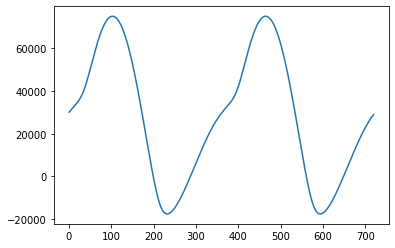

In [9]:
data = df.loc[(df['latitude'] == 45) & (df['longitude'] == 60)] \
    .sort_values('time_step')

import matplotlib.pyplot as plt

plt.plot(data['time_step'], data['principal1'])
data

In [19]:
import numpy as np
import legacy.StressEQs as stress1
import StressEquations as stress2

In [20]:
result1 = stress1.getStress(
    interior=1, 
    e_in=0.01, 
    colat=np.radians(45), 
    lon=np.radians(60), 
    steps=360, 
    this_step=5,
    oblq=0.1,
    phase=0.1,
    NSRdelta=42
)
print(result1)

result2 = stress2.getStress(
    interior_value='interior1', 
    e_in=0.01, 
    colat=np.radians(45), 
    lon=np.radians(60), 
    steps=360, 
    this_step=5,
    oblq=0.1,
    phase=0.1,
    NSRdelta=42
)
print(result2)

abs(np.array(result1) - np.array(result2))

(71.8810108076292, 3.2669857015654484)
(71.88101084929254, 3.2669857043257293)


array([4.16633412e-08, 2.76028089e-09])

In [21]:
import utils

value = utils.import_interior('interior1')
display(value)

In [22]:
value.modal_strengths

[-3.425221799746515e-12,
 -1.0256907477820026e-11,
 -1.4253580481622307e-11,
 -1.0926996197718631e-10,
 -5.768155893536122e-06,
 -3.247433460076046e-05]

In [23]:
import numpy as np

points = [
    (1, 1),
    (2, 3),
    (4, 5),
    (6, 7),
    (8, 8),
    (11, 6),
    (12, 4),
    (12, 1)
]
points = np.array(points)

In [24]:
import curves.fitCurves as fit

result = fit.fitCurve(points, 1)
result

[[array([1, 1]),
  array([4.17726084, 7.35452168]),
  array([12.        , 10.86410171]),
  array([12,  1])]]

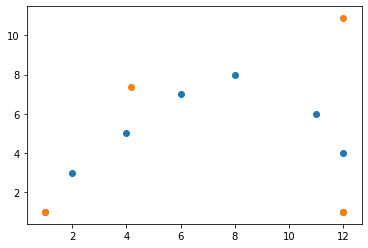

In [25]:
x = [point[0] for point in points]
y = [point[1] for point in points]

x2 = [point[0] for point in result[0]]
y2 = [point[1] for point in result[0]]

import matplotlib.pyplot as plt
plt.scatter(x, y)
plt.scatter(x2, y2)

### Cubic Bezier Equation

$$B'(t) = (1 - t)^3P_0 + 3(1 - t)^2tP_1 + 3(1-t)t^2P_2 + t^3P_3, 0 \le t \le 1$$

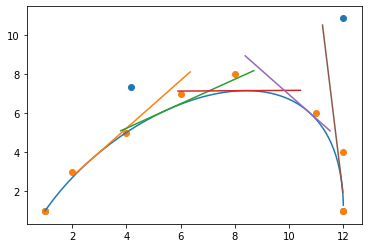

In [26]:
import numpy as np
import curves.bezier as bezier
import StressEquations as stress
import utils

curve = result[0]

bpoints = []
for t in np.arange(0, 1, 0.01):
    point = bezier.q(result[0], t)
    bpoints.append(point)
    
x = [point[0] for point in bpoints]
y = [point[1] for point in bpoints]

x2 = [point[0] for point in result[0]]
y2 = [point[1] for point in result[0]]

x3 = [point[0] for point in points]
y3 = [point[1] for point in points]

import matplotlib.pyplot as plt
plt.plot(x, y)
plt.scatter(x2, y2)
plt.scatter(x3, y3)

for time in np.arange(0.15, 1, 0.2):
    direction = bezier.findCubicRPoints(curve, time)
    dirX = [point[0] for point in direction]
    dirY = [point[1] for point in direction]
    plt.plot(dirX, dirY)


## Observed Cycloids

In [27]:
import pandas as pd

df = pd.read_csv("./obsData/AlexLonLatCut.txt", header=None, sep=' ', names=['lon', 'lat'])
df

,lon,lat
0,10.867,17.140
1,10.925,17.221
2,11.041,17.326
3,11.168,17.418
4,11.389,17.511
...,...,...
67,30.526,14.576
68,31.191,14.012
69,31.552,13.742
70,31.833,13.494


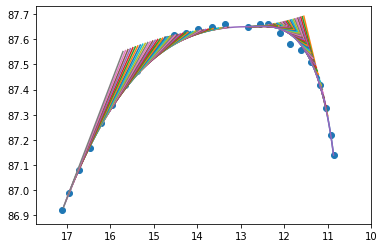

In [28]:
firstArc = df[0:26]

def translate(point):
    return (point[0], point[1] + 70)
    
points = np.array(firstArc)
points = np.array(list(map(translate, points)))

controls = fit.fitCurve(points, 0.05)


plt.xlim(17.7, 10)
# plt.ylim(15, 18)

plt.scatter(firstArc['lon'], firstArc['lat'] + 70)
# plt.scatter(x, y)

bpoints = []

for control in controls:
    for t in np.arange(0, 1, 0.01):
        point = bezier.q(control, t)
        bpoints.append(point)
    
    x = [point[0] for point in bpoints]
    y = [point[1] for point in bpoints]
    plt.plot(x, y)
    
    for time in np.arange(0.15, 1, 0.02):
        direction = bezier.findCubicRPoints(control, time)
        dirX = [point[0] for point in direction]
        dirY = [point[1] for point in direction]
        plt.plot(dirX, dirY)

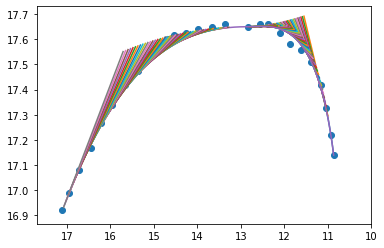

In [29]:
points = np.array(firstArc)

controls2 = fit.fitCurve(points, 0.05)


plt.xlim(17.7, 10)
# plt.ylim(15, 18)

plt.scatter(firstArc['lon'], firstArc['lat'])
# plt.scatter(x, y)

bpoints = []

for control in controls2:
    for t in np.arange(0, 1, 0.01):
        point = bezier.q(control, t)
        bpoints.append(point)
    
    x = [point[0] for point in bpoints]
    y = [point[1] for point in bpoints]
    plt.plot(x, y)
    
    for time in np.arange(0.15, 1, 0.02):
        direction = bezier.findCubicRPoints(control, time)
        dirX = [point[0] for point in direction]
        dirY = [point[1] for point in direction]
        plt.plot(dirX, dirY)

In [ ]:
points

In [ ]:
controls

# Try fitting Delphi

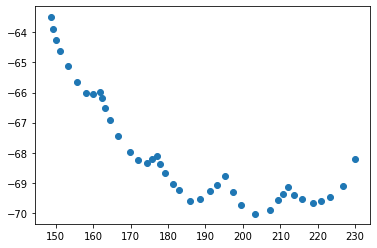

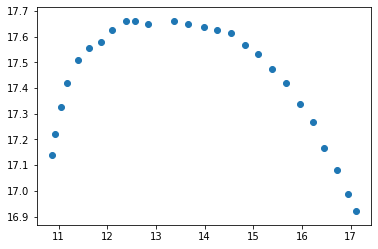

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import curves.bezier as bezier
import curves.fitCurves as fit
import curves.fitArcs as fitArcs
import StressTools as tools

def round_heading(value, base=5):
    return base * round(value / base)

def calculate_loss(frame):
    diffs = np.diff(frame.sort_values('pointNumber')['pointNumber'])
    
    edges = frame.iloc[[0, -1]]
    startDiff = edges.iloc[0].pointNumber - 1
    endDiff = 100 - edges.iloc[1].pointNumber
    
    diffs = np.append(diffs, [startDiff, endDiff])
    return max(diffs)

TOLERANCE = 1

delphi = pd.read_csv("./obsData/DelphiLonLatAT.txt", header=None, sep=' ', names=['lon', 'lat'])
delphi = delphi.sort_values(['lon', 'lat'])

plt.scatter(delphi['lon'], delphi['lat'])

plt.figure()

plt.scatter(firstArc['lon'], firstArc['lat'])


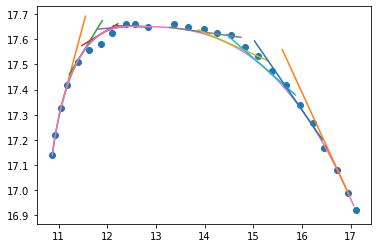

In [31]:
points = np.array(firstArc)

controls = fit.fitCurve(points, 0.05)

# plt.xlim(17.7, 10)
# plt.ylim(15, 18)

def findHeading(points, reverse = False):
    if reverse:
        origin = 1
        destination = 0
    else:
        origin = 0
        destination = 1
        
    rise = points[destination][1] - points[origin][1] # lats
    run = points[destination][0] - points[origin][0]  # lons
    
    degrees = np.degrees(np.arctan2(run, rise))
    if degrees < 0:
        degrees += 360
    return degrees if degrees > 180 else degrees + 180

bpoints = []
rows = []

plt.scatter(firstArc['lon'], firstArc['lat'])

pointNumber = 1
for control in controls:
    for t in np.arange(0, 1, 0.01):
        point = bezier.q(control, t)
        bpoints.append(point)
    
        heading = findHeading(bezier.findCubicRPoints(control, t), False)
        heading_reverse = findHeading(bezier.findCubicRPoints(control, t), True)
        rowData = {
            'pointNumber': pointNumber,
            'lon': point[0],
            'lat': point[1],
            'heading': heading,
            'headingCategory': round_heading(heading, TOLERANCE),
            'headingReverse': heading_reverse,
            'headingCategoryReverse': round_heading(heading_reverse, TOLERANCE)
        }
        rows.append(rowData)
        pointNumber += 1
        
    x = [point[0] for point in bpoints]
    y = [point[1] for point in bpoints]
    plt.plot(x, y)
    
    for time in np.arange(0.15, 1, 0.2):
        direction = bezier.findCubicRPoints(control, time)
        dirX = [point[0] for point in direction]
        dirY = [point[1] for point in direction]
        plt.plot(dirX, dirY)
        
df = pd.DataFrame(rows)
# df

In [32]:
def fit_arc(arc, max_error=0.05, reverse=False):
    points = np.array(arc)
    controls = fit.fitCurve(points, max_error)
    
    if reverse:
        controls = controls[::-1]
    
    rows = []
    pointNumber = 1
    for control in controls:
        if reverse:
            control.reverse()
        for time in np.arange(0, 1, 0.01):
            point = bezier.q(control, time)

            heading = findHeading(bezier.findCubicRPoints(control, time))
            rows.append({
                'pointNumber': pointNumber,
                'lon': point[0],
                'lat': point[1],
                'heading': heading,
                'headingCategory': round_heading(heading, TOLERANCE)
            })
            pointNumber += 1
                
    return pd.DataFrame(rows)

### Generate stress field based on our list of coordinates

In [33]:
import StressEquations as stress
import utils

interior = utils.import_interior('interior1')

stresses = []


for point in df.itertuples():
    for step in range(360):
        current = stress.getStress(
            interior_value=interior, 
            e_in=0.01, 
            colat=np.radians(90-point.lat), 
            lon=np.radians(360-point.lon), 
            steps=360, 
            this_step=step,
            oblq=0.25,
            phase=90,
            NSRdelta=0)
        heading_degrees = np.degrees(current[1])
        stresses.append({
            'lon': point.lon,
            'lat': point.lat,
            'stress': current[0],
            'heading': heading_degrees,
            'headingCategory': round_heading(heading_degrees, TOLERANCE),
            'time': step
        })
        
stressFrame = pd.DataFrame(stresses)


In [34]:
def build_stress_field(interior, pointFrame, phase):
    for point in pointFrame.itertuples():
        for step in range(360):
            current = stress.getStress(
                interior_value=interior, 
                e_in=0.01, 
                colat=np.radians(90-point.lat), 
                lon=np.radians(360-point.lon), 
                steps=360, 
                this_step=step,
                oblq=0.25,
                phase=np.radians(phase),
                NSRdelta=0)
            heading_degrees = np.degrees(current[1])
            stresses.append({
                'lon': point.lon,
                'lat': point.lat,
                'stress': current[0],
                'heading': heading_degrees,
                'headingCategory': round_heading(heading_degrees, TOLERANCE),
                'time': step
            })

    return pd.DataFrame(stresses)

### Search for matches in headings between curve and stress field

In [35]:
# Forward propagation

merged = df.merge(
    stressFrame,
    how='left',
    on=['lon', 'lat', 'headingCategory']
)

In [36]:
# merged.loc[not df.isnull(merged['stress'])]
merged = merged.loc[merged['stress'] > 0]
merged['maxStress'] = merged.groupby('pointNumber')['stress'].transform('max')
merged_unique = merged.loc[merged['stress'] == merged['maxStress']]

calculate_loss(merged_unique)

128.0

In [37]:
def match_orientations(curve, stresses):
    merged = curve.merge(
        stresses,
        how='left',
        on=['lon', 'lat', 'headingCategory']
    )
    merged = merged.loc[merged['stress'] > 0]
    merged['maxStress'] = merged.groupby('pointNumber')['stress'].transform('max')
    merged_unique = merged.loc[merged['stress'] == merged['maxStress']]
    
    return merged_unique

In [38]:
# Reverse propagation

# merged = df.merge(
#     stressFrame,
#     how='left',
#     left_on=['lon', 'lat', 'headingCategoryReverse'],
#     right_on=['lon', 'lat', 'headingCategory']
# )

# print(len(merged))
# merged.loc[merged['stress'] > 0]

# # merged.groupby(['lon', 'lat']).size()
# # merged = merged.loc[merged['stress'] > 0]
# merged['maxStress'] = merged.groupby(['lon', 'lat'])['stress'].transform('max')

# merged_unique = merged.loc[merged['stress'] == merged['maxStress']]
# display(merged_unique)
# display(merged)


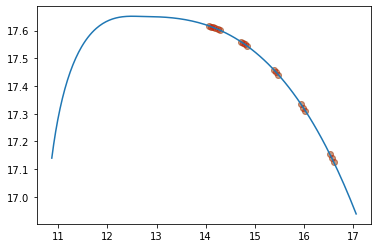

In [39]:
plt.scatter(merged_unique['lon'], merged_unique['lat'], alpha=0.3, color='green')

positive = merged_unique.loc[merged_unique['stress'] > 0]
plt.scatter(positive['lon'], positive['lat'], alpha=0.3, color='red')

x = [point[0] for point in bpoints]
y = [point[1] for point in bpoints]
plt.plot(x, y)

### Brute force search phases

In [24]:
results = []

for phase in range(0, 360, 20):
    field = build_stress_field(interior, df, phase)
    matches = match_orientations(df, field)
    loss = calculate_loss(matches)
    
    results.append({
        'phase': phase,
        'error': loss
    })
    print(f'Calculated for phase {phase}')
    
results = pd.DataFrame(results)
results

Calculated for phase 0
Calculated for phase 20
Calculated for phase 40
Calculated for phase 60
Calculated for phase 80
Calculated for phase 100
Calculated for phase 120
Calculated for phase 140
Calculated for phase 160
Calculated for phase 180
Calculated for phase 200
Calculated for phase 220
Calculated for phase 240
Calculated for phase 260
Calculated for phase 280
Calculated for phase 300
Calculated for phase 320
Calculated for phase 340


,phase,error
0,0,9.0
1,20,9.0
2,40,9.0
3,60,9.0
4,80,9.0
5,100,9.0
6,120,9.0
7,140,9.0
8,160,9.0
9,180,9.0


In [40]:
def test_arc(arc, phase_increment):
    results = []

    for phase in range(0, 361, phase_increment):
        field = build_stress_field(interior, arc, phase)
        matches = match_orientations(arc, field)
        loss = calculate_loss(matches)

        results.append({
            'phase': phase,
            'error': loss
        })
        print(f'Calculated for phase {phase}')

    return pd.DataFrame(results) 
    

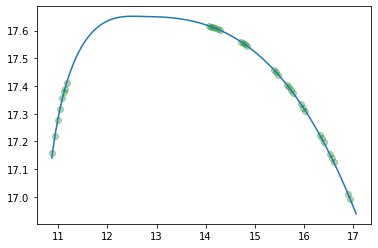

In [41]:
field = build_stress_field(interior, df, 300)
matches = match_orientations(df, field)

plt.scatter(matches['lon'], matches['lat'], alpha=0.3, color='green')

x = [point[0] for point in bpoints]
y = [point[1] for point in bpoints]
plt.plot(x, y)

(array([12.,  1.,  8.,  1.,  5.,  1.,  1.,  4.,  0.,  3.]),
 array([ 2.45716441,  6.4894701 , 10.52177579, 14.55408148, 18.58638717,
        22.61869286, 26.65099856, 30.68330425, 34.71560994, 38.74791563,
        42.78022132]),
 <a list of 10 Patch objects>)

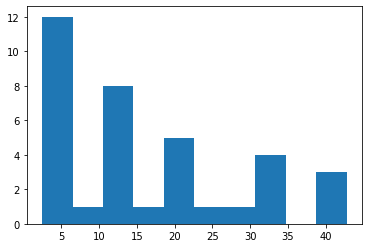

In [42]:
plt.hist(matches['stress'])

<BarContainer object of 36 artists>

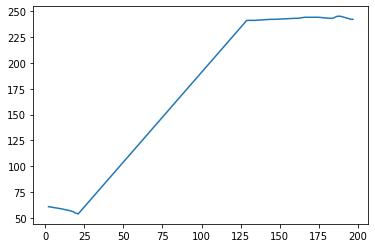

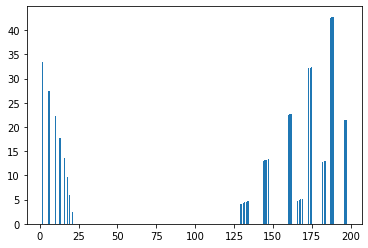

In [43]:
plt.plot(matches['pointNumber'], matches['time'])
plt.figure()
plt.bar(matches['pointNumber'], matches['stress'])

### Experiment: Reversing the control points in a Bezier results in the same exact curve

[array([12.838, 17.65 ]),
 array([14.32154658, 17.65      ]),
 array([15.73825601, 17.54916224]),
 array([17.106, 16.92 ])]

[array([17.106, 16.92 ]),
 array([15.73825601, 17.54916224]),
 array([14.32154658, 17.65      ]),
 array([12.838, 17.65 ])]

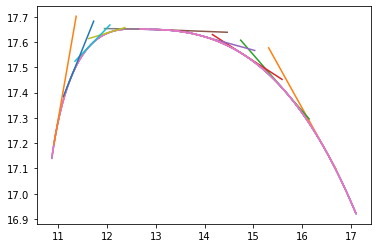

In [44]:
control_rev = control[::-1]
display(control)
display(control_rev)

for control in controls[::-1]:
    control.reverse()
    for t in np.arange(0, 1, 0.01):
        point = bezier.q(control, t)
        bpoints.append(point)
    
    x = [point[0] for point in bpoints]
    y = [point[1] for point in bpoints]
    plt.plot(x, y)
    
    for time in np.arange(0.15, 1, 0.2):
        direction = bezier.findCubicRPoints(control, time)
        dirX = [point[0] for point in direction]
        dirY = [point[1] for point in direction]
        plt.plot(dirX, dirY)

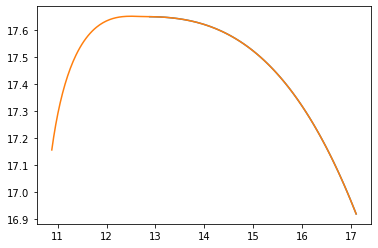

In [45]:
controls = fit.fitCurve(points, 0.05)

bpoints = []
rows = []

pointNumber = 1
for control in controls[::-1]:
    control.reverse()

    for t in np.arange(0, 1, 0.01):
        point = bezier.q(control, t)
        bpoints.append(point)
    
        heading = findHeading(bezier.findCubicRPoints(control, t), False)
        heading_reverse = findHeading(bezier.findCubicRPoints(control, t), True)
        rowData = {
            'pointNumber': pointNumber,
            'lon': point[0],
            'lat': point[1],
            'heading': heading,
            'headingCategory': round_heading(heading, TOLERANCE),
            'headingReverse': heading_reverse,
            'headingCategoryReverse': round_heading(heading_reverse, TOLERANCE)
        }
        rows.append(rowData)
        pointNumber += 1
        
    x = [point[0] for point in bpoints]
    y = [point[1] for point in bpoints]
    plt.plot(x, y)
        
df_reverse = pd.DataFrame(rows)

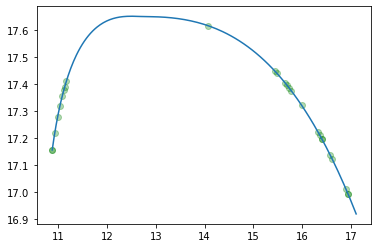

In [46]:
field = build_stress_field(interior, df_reverse, 300)
matches = match_orientations(df_reverse, field)

plt.scatter(matches['lon'], matches['lat'], alpha=0.3, color='green')

x = [point[0] for point in bpoints]
y = [point[1] for point in bpoints]
plt.plot(x, y)

<BarContainer object of 26 artists>

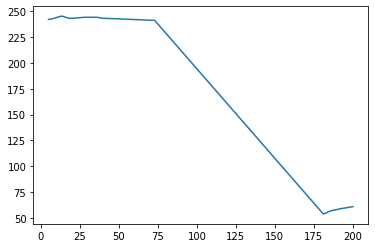

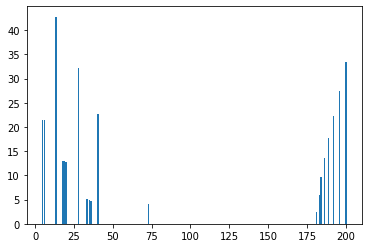

In [47]:
plt.plot(matches['pointNumber'], matches['time'])
plt.figure()
plt.bar(matches['pointNumber'], matches['stress'])

In [48]:
display(df)
display(df_reverse)

,pointNumber,lon,lat,heading,headingCategory,headingReverse,headingCategoryReverse
0,1,10.867000,17.140000,215.604534,216.0,215.604534,216.0
1,2,10.879353,17.156840,216.919578,217.0,216.919578,217.0
2,3,10.892025,17.173310,218.229722,218.0,218.229722,218.0
3,4,10.905010,17.189413,219.533501,220.0,219.533501,220.0
4,5,10.918302,17.205152,220.829487,221.0,220.829487,221.0
...,...,...,...,...,...,...,...
195,196,16.900469,17.010465,292.813293,293.0,292.813293,293.0
196,197,16.941635,16.992991,293.188469,293.0,293.188469,293.0
197,198,16.982770,16.975210,293.565040,294.0,293.565040,294.0
198,199,17.023876,16.957119,293.942937,294.0,293.942937,294.0


,pointNumber,lon,lat,heading,headingCategory,headingReverse,headingCategoryReverse
0,1,17.106000,16.920000,294.702430,295.0,294.702430,295.0
1,2,17.064953,16.938717,294.322091,294.0,294.322091,294.0
2,3,17.023876,16.957119,293.942937,294.0,293.942937,294.0
3,4,16.982770,16.975210,293.565040,294.0,293.565040,294.0
4,5,16.941635,16.992991,293.188469,293.0,293.188469,293.0
...,...,...,...,...,...,...,...
195,196,10.931897,17.220533,222.116300,222.0,222.116300,222.0
196,197,10.918302,17.205152,220.829487,221.0,220.829487,221.0
197,198,10.905010,17.189413,219.533501,220.0,219.533501,220.0
198,199,10.892025,17.173310,218.229722,218.0,218.229722,218.0


In [49]:
controls

[[array([12.838, 17.65 ]),
  array([12.21896038, 17.65      ]),
  array([11.27341366, 17.7075777 ]),
  array([10.867, 17.14 ])],
 [array([17.106, 16.92 ]),
  array([15.73825601, 17.54916224]),
  array([14.32154658, 17.65      ]),
  array([12.838, 17.65 ])]]

## Lets try to do the entire cycloid

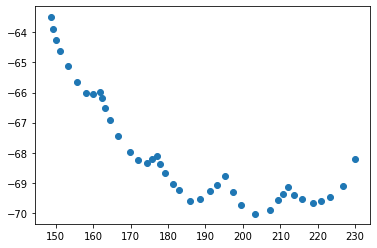

In [50]:
plt.scatter(delphi['lon'], delphi['lat'])

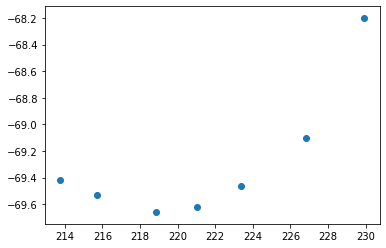

In [51]:
temp = delphi[34:]

plt.scatter(temp['lon'], temp['lat'])

In [52]:
arcs = [
    delphi[0:9],
    delphi[9:18],
    delphi[18:27],
    delphi[27:34],
    delphi[34:]
]

In [1]:
all_curves = None
all_arcs = None

for arc in arcs:
    curve = fit_arc(arc)
    all_curves = curve if all_curves is None else pd.concat([all_curves, curve], ignore_index=True)
    field = get_stress_field(interior, curve, 300)
        
    matches = match_orientations(curve, field)
    all_arcs = matches if all_arcs is None else pd.concat([all_arcs, matches], ignore_index=True)
    print("Finished an arc...")


NameError: name 'arcs' is not defined

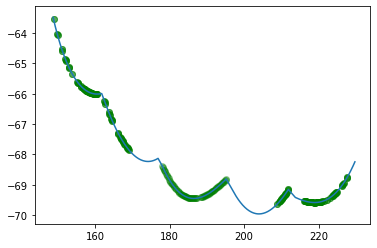

In [60]:
plt.plot(all_curves['lon'], all_curves['lat'])
# plt.scatter(delphi['lon'], delphi['lat'])
plt.scatter(all_arcs['lon'], all_arcs['lat'], alpha=0.3, color='green')

In [58]:
curve = fit_arc(arcs[2])
results = test_arc(curve, 10)
display(results)

Calculated for phase 0
Calculated for phase 10
Calculated for phase 20
Calculated for phase 30
Calculated for phase 40
Calculated for phase 50
Calculated for phase 60
Calculated for phase 70
Calculated for phase 80
Calculated for phase 90
Calculated for phase 100
Calculated for phase 110
Calculated for phase 120
Calculated for phase 130
Calculated for phase 140
Calculated for phase 150
Calculated for phase 160
Calculated for phase 170
Calculated for phase 180
Calculated for phase 190
Calculated for phase 200
Calculated for phase 210
Calculated for phase 220
Calculated for phase 230
Calculated for phase 240
Calculated for phase 250
Calculated for phase 260
Calculated for phase 270
Calculated for phase 280
Calculated for phase 290
Calculated for phase 300
Calculated for phase 310
Calculated for phase 320
Calculated for phase 330
Calculated for phase 340
Calculated for phase 350
Calculated for phase 360


,phase,error
0,0,56.0
1,10,45.0
2,20,13.0
3,30,9.0
4,40,9.0
5,50,9.0
6,60,9.0
7,70,9.0
8,80,9.0
9,90,9.0


# ~TODO: Add diffs to stress field frame to determine increase or decrease~
# TODO: Allow heading match tolerance < 1 degree


In [74]:
all_arcs

,pointNumber,lon,lat,heading_x,headingCategory,stress,heading_y,time,maxStress
0,2,148.749713,-63.543963,297.886436,298.0,132.472097,297.532406,69.0,132.472097
1,10,149.723525,-64.020841,294.330025,294.0,121.197096,293.588114,68.0,121.197096
2,11,149.847167,-64.076188,293.900534,294.0,121.197954,293.664491,68.0,121.197954
3,20,150.977326,-64.533298,290.189759,290.0,111.002725,290.277362,67.0,111.002725
4,21,151.104710,-64.579642,289.794762,290.0,111.018365,290.381566,67.0,111.018365
...,...,...,...,...,...,...,...,...,...
268,87,227.677066,-68.761532,258.023047,258.0,81.491614,258.386525,241.0,81.491614
269,88,227.837606,-68.727064,257.741971,258.0,41.803118,258.352876,207.0,41.803118
270,93,228.641089,-68.542007,256.313399,256.0,47.904788,256.163069,206.0,47.904788
271,94,228.801959,-68.502400,256.023348,256.0,48.063940,256.334907,206.0,48.063940


# Let's do this cleaner

In [1]:
import pandas as pd
# import matplotlib.pyplot as plt
import numpy as np
import curves.bezier as bezier
import curves.fitCurves as fit
import StressTools as tools
import utils
import fitting

interior = utils.import_interior('interior1')

TOLERANCE = 1

delphi = pd.read_csv("./obsData/DelphiLonLatAT.txt", header=None, sep=' ', names=['lon', 'lat'])
delphi = delphi.sort_values(['lon', 'lat'])

arcs = [
    delphi[0:9],
    delphi[9:18],
    delphi[18:27],
    delphi[27:34],
    delphi[34:]
]


all_curves = None
all_arcs = None
all_stress = None

for index, arc in enumerate(arcs):
    startingPoint = index * 100 + 1
    curve = fitting.fit_arc(arc, startingPoint=startingPoint)
    curve['lon'] = curve['lon'] + 60
    all_curves = curve if all_curves is None else pd.concat([all_curves, curve], ignore_index=True)
    field = tools.get_simon_stress_field(
        interior, 
        curve, 
        90,
        0.01,
        0.44,
        0,
        is_async=True, 
        steps=850)
        
    matches = fitting.match_orientations(curve, field, positive_only=True)
    all_arcs = matches if all_arcs is None else pd.concat([all_arcs, matches], ignore_index=True)
    all_stress = field if all_stress is None else pd.concat([all_stress, field], ignore_index=True)
    print("Finished an arc...")

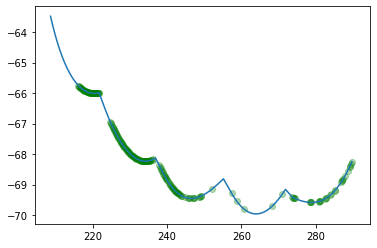

In [3]:
import matplotlib.pyplot as plt

plt.plot(all_curves['lon'], all_curves['lat'])
plt.scatter(all_arcs['lon'], all_arcs['lat'], alpha=0.3, color='green')

In [4]:
fit_data = fitting.test_arc(
    all_curves, 
    10, 
    interior,
    0.01,
    0.44,
    0,
    steps=850, 
    positive_only=True)

Calculated for phase 0
Calculated for phase 10
Calculated for phase 20
Calculated for phase 30
Calculated for phase 40
Calculated for phase 50
Calculated for phase 60
Calculated for phase 70
Calculated for phase 80
Calculated for phase 90
Calculated for phase 100
Calculated for phase 110
Calculated for phase 120
Calculated for phase 130
Calculated for phase 140
Calculated for phase 150
Calculated for phase 160
Calculated for phase 170
Calculated for phase 180
Calculated for phase 190
Calculated for phase 200
Calculated for phase 210
Calculated for phase 220
Calculated for phase 230
Calculated for phase 240
Calculated for phase 250
Calculated for phase 260
Calculated for phase 270
Calculated for phase 280
Calculated for phase 290
Calculated for phase 300
Calculated for phase 310
Calculated for phase 320
Calculated for phase 330
Calculated for phase 340
Calculated for phase 350
Calculated for phase 360


,phase,error
0,0,154.0
1,10,167.0
2,20,187.0
3,30,199.0
4,40,152.0
5,50,143.0
6,60,105.0
7,70,72.0
8,80,88.0
9,90,58.0


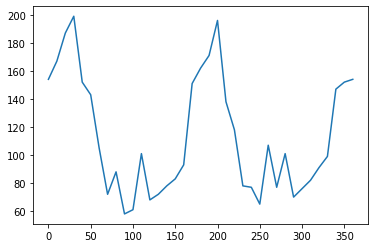

In [5]:
plt.plot(fit_data['phase'], fit_data['error'])
display(fit_data)

In [3]:
error = fitting.find_heading_error(all_curves, all_stress)

(array([385.,  37.,  15.,  10.,  10.,   9.,   9.,   7.,   2.,  16.]),
 array([1.12931207e-03, 3.86888112e+00, 7.73663292e+00, 1.16043847e+01,
        1.54721365e+01, 1.93398883e+01, 2.32076401e+01, 2.70753920e+01,
        3.09431438e+01, 3.48108956e+01, 3.86786474e+01]),
 <a list of 10 Patch objects>)

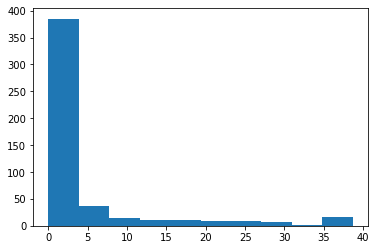

In [4]:
plt.hist(error['deltaHeading'])

In [15]:
ITERATIONS = 1
BATCH_SIZE = 32

# params = np.array([90, 0.44, 30]) # phase, obliquity, longitude
params = np.array([0.25, 0.07, 0.15]) # phase, obliquity, longitude
min_vals = np.array([0, 0, 1])
max_vals = np.array([360, np.pi * 2, 180])

def gradient(batch):
    variables = params * max_vals + min_vals
    test_data = batch.copy()
    test_data['lon'] = test_data['lon'] + variables[2]
    
    field = tools.get_simon_stress_field(
        interior, 
        test_data, 
        phase=variables[0],
        eccentricity=0.01,
        obliquity=variables[1],
        nsr=0,
        is_async=True, 
        steps=850)
    error = fitting.find_heading_error(test_data, field)
    heading_error = error['deltaHeading']
    norm_error = (heading_error - heading_error.min()) / (heading_error.max() - heading_error.min())

    return norm_error, field

for iter in range(1, ITERATIONS + 1):
    batch = all_curves.sample(BATCH_SIZE)
    result, field = gradient(batch)
    


________________________________________________________________________________
[Memory] Calling StressTools.build_simon_stress_field...
build_simon_stress_field(<utils.Interior object at 0x7f84e0b0b3d0>,      pointNumber         lon        lat     heading  headingCategory
213          214  268.189861 -68.898716  280.821546            281.0
412          413  303.744498 -69.518009  272.340047            272.0
79            80  246.993819 -65.984548  272.189180            272.0
413          414  303.908829 -69.524591  272.246235            272.0
377          378  296.651553 -69.666778  263.018020            263.0
327          328  289.354657 -69.861349  274.526766            275.0
326          327  289.208371 -69.849429  274.790157            275.0
32            33  240.657805 -65.069841  285.324300            285.0
188          189  263.193801 -68.218868  268.317429            268.0
178       ..., phase=90.0, eccentricity=0.01, obliquity=0.4398229715025711, nsr=0, is_async=True, steps=

In [6]:
def loss(params):
    print(f"Running loss function with params {params}")
    phase, obliquity, longitude = params
    test_data = all_curves.copy()
    test_data['lon'] = test_data['lon'] + longitude
    
    field = tools.get_simon_stress_field(
        interior, 
        test_data, 
        phase=phase,
        eccentricity=0.01,
        obliquity=obliquity,
        nsr=0,
        is_async=True, 
        steps=360)
    error = fitting.find_heading_error(test_data, field)
    result = error['deltaHeading']
    
    root_mean_squared_error = np.sqrt(np.sum(np.power(result, 2))) / result.shape[0]
    
    print(f'Loss Output: {root_mean_squared_error}')
    return root_mean_squared_error

def loss_der(params):
    phase, obliquity, longitude = params
    test_data = all_curves.copy()
    test_data['lon'] = test_data['lon'] + longitude
    
    field = tools.get_simon_stress_field(
        interior, 
        test_data, 
        phase=phase,
        eccentricity=0.01,
        obliquity=obliquity,
        nsr=0,
        is_async=True, 
        steps=360)
    error = fitting.find_heading_error(test_data, field)
    result = error['deltaHeading']    
    
    # calculate jacobian
    diffs = np.insert(np.diff(result), 0, result.iloc[0], axis=0)
    jac = np.array([[error/param for param in params] for error in diffs])
    
    root_mean_squared_error = np.sqrt(np.sum(np.power(result, 2))) / result.shape[0]

    loss_vector = np.array([root_mean_squared_error/error for error in result])
    
    return loss_vector @ jac

  

In [7]:
from scipy.optimize import minimize


initial = [90, 0.44, 60]
opt = minimize(loss, initial, method='L-BFGS-B', jac=loss_der,
               bounds=[(0, 360), (0, 1), (0, 360)],
               options={ 'maxiter': 5000, 'disp': 1})

Running loss function with params [90.    0.44 60.  ]
Loss Output: 0.3411638430737436
Running loss function with params [91.97226475  1.         62.95839713]
Loss Output: 0.3850077379683605
Running loss function with params [90.56414634  0.60018232 60.8462195 ]
Loss Output: 0.35271823789109646
Running loss function with params [90.15819055  0.48491624 60.23728583]
Loss Output: 0.35424203677252747
Running loss function with params [90.04098493  0.45163716 60.0614774 ]
Loss Output: 0.3501917910917616
Running loss function with params [90.00685361  0.441946   60.01028042]
Loss Output: 0.34283886540086744
Running loss function with params [90.00175594  0.44049858 60.00263392]
Loss Output: 0.3414344835012022
Running loss function with params [90.00047017  0.4401335  60.00070525]
Loss Output: 0.34123303432832913
Running loss function with params [90.00012432  0.4400353  60.00018648]
Loss Output: 0.34118198506776376
Running loss function with params [90.00002293  0.44000651 60.00003439]
Loss 

In [11]:
result = loss([90, 0.44, 60])

In [12]:
result

0.32359810520777293

In [72]:
opt

      fun: 0.3411638430737895
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([  -1.97226475, -403.41779017,   -2.95839713])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 21
      nit: 0
   status: 2
  success: False
        x: array([90.  ,  0.44, 60.  ])

In [6]:
loss([89.98245796,  0.36734444, 59.99706506])

0.33778615223444164

In [14]:
def stress_match(params):
    phase, obliquity, longitude = params
    test_data = all_curves.copy()
    test_data['lon'] = test_data['lon'] + longitude
    
    field = tools.get_simon_stress_field(
        interior, 
        test_data, 
        phase=phase,
        eccentricity=0.01,
        obliquity=np.radians(obliquity),
        nsr=0,
        is_async=True, 
        steps=360)
    result = fitting.find_heading_error(test_data, field)
    
    return result

In [19]:
result = stress_match([89.98245796,  0.36734444, 59.99706506])

## Trying out Adam optimizer

In [1]:
min_vals = np.array([0, 0.01])
max_vals = np.array([360, 1])

def objective(batch, params):
#     print(f"Running objective function with params {params}")
    variables = params * (max_vals - min_vals) + min_vals # denormalize
    phase, obliquity = variables
    test_data = batch.copy()
#     test_data['lon'] = test_data['lon'] + longitude
    
    field = tools.get_simon_stress_field(
        interior, 
        test_data, 
        phase=phase,
        eccentricity=0.01,
        obliquity=np.radians(obliquity),
        nsr=0,
        is_async=True, 
        steps=360)
    error = fitting.find_heading_error(test_data, field)
    if len(error) == 0:
        print('NO Positive Stresses found!')
        print(variables)
        
    result = error['deltaHeading']
    
    root_mean_squared_error = np.sqrt(np.sum(np.power(result, 2))) / result.shape[0]
    
     # calculate jacobian & gradient
    diffs = np.insert(np.diff(result), 0, result.iloc[0], axis=0)
    jac = np.array([[(-1*error)/param for param in params] for error in diffs])
    loss_vector = np.array([root_mean_squared_error/error for error in result])
    gradient = loss_vector @ jac
    
    print(f'Loss Output: {root_mean_squared_error}')
    
    return root_mean_squared_error, gradient

NameError: name 'np' is not defined

In [7]:
alpha = 1e-3
beta1 = 0.9
beta2 = 0.999
epsilon = 1e-8

ITERATIONS = 180
CONVERGE_THRESHOLD = 0.01
BATCH_SIZE = 32

params = np.array([0.25, 0.07]) # phase, obliquity

best_case = dict(loss=100, parameters=params)
worst_case = dict(loss=0, parameters=params)
losses = []

# variables = params * max_vals + min_vals

moment = [np.zeros_like(params)]
raw_moment = [np.zeros_like(params)]


# for iteration in range(1, ITERATIONS + 1):
loss = 100
iteration = 1
while loss > CONVERGE_THRESHOLD and iteration < ITERATIONS:
    batch = all_curves.sample(BATCH_SIZE)
    
    loss, gradient = objective(batch, params)
    
    losses.append(loss)
    if loss < best_case['loss']:
        best_case['loss'] = loss
        best_case['parameters'] = params
        
    if loss > worst_case['loss']:
        worst_case['loss'] = loss
        worst_case['parameters'] = params
    
    
    moment.append(beta1 * moment[iteration - 1] + (1. - beta1) * gradient)
    raw_moment.append(beta2 * raw_moment[iteration - 1]  + (1. - beta2) * gradient**2)
    
#     corrected_moment = moment[iteration]/(1. - beta1**iteration)
#     corrected_raw = raw_moment[iteration]/(1. - beta2**iteration)
    
    learning_rate = alpha * (np.sqrt(1. - beta2**iteration)/(1. - beta1**iteration))
    params = params - learning_rate * moment[iteration]/(np.sqrt(raw_moment[iteration]) + epsilon)
#     params = params - alpha * corrected_moment/(np.sqrt(corrected_raw) + epsilon)
    params[params >=  1] = 1
    params[params <= 0] = epsilon
    
    iteration += 1
    
    

Loss Output: 0.026049483813718737
Loss Output: 0.024914882905429373
Loss Output: 0.030116872591156023
Loss Output: 0.02835961698276721
Loss Output: 0.02376126445782041
Loss Output: 0.029414972936448104
Loss Output: 0.034800763659049876
Loss Output: 0.025317977538148
Loss Output: 0.026048861789352885
Loss Output: 0.02696988981507881
Loss Output: 0.02740505621885699
Loss Output: 0.023607044329352324
Loss Output: 0.025163648299438214
Loss Output: 0.028255562791714667
Loss Output: 0.02569489576589776
Loss Output: 0.026043456409887707
Loss Output: 0.023945392412775556
Loss Output: 0.03017324362595049
Loss Output: 0.02519340968591447
Loss Output: 0.024911742455528615
Loss Output: 0.027307075658848948
Loss Output: 0.02509980436200674
Loss Output: 0.027467140540983523
Loss Output: 0.020411265985674977
Loss Output: 0.027533445293844692
Loss Output: 0.02595384505186029
Loss Output: 0.02344416409308457
Loss Output: 0.03031302491799449
Loss Output: 0.027745003562005204
Loss Output: 0.0272188616220

In [8]:
variables = best_case['parameters'] * (max_vals - min_vals) + min_vals
bad_vars = worst_case['parameters'] * (max_vals - min_vals) + min_vals
print(variables)
print(bad_vars)

[6.41851133e+01 1.00000099e-02]
[8.79959077e+01 7.37962378e-02]


In [9]:
display(best_case)
display(worst_case)

{'loss': 0.01998710280651097,
 'parameters': array([1.78291981e-01, 1.00000000e-08])}

{'loss': 0.034800763659049876, 'parameters': array([0.24443308, 0.06444064])}

In [10]:
variables = np.append(variables, 0)
bad_vars = np.append(bad_vars, 0)

data = stress_match(variables)
bad_data = stress_match(bad_vars)


In [14]:
data = stress_match([0, 0, 0])

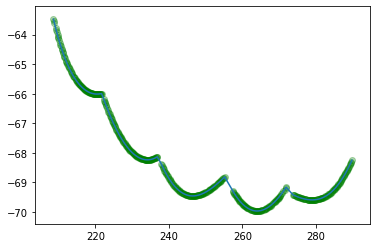

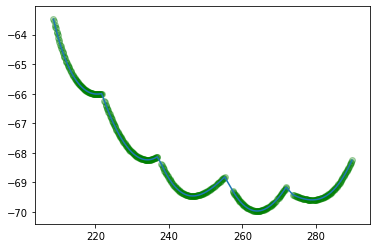

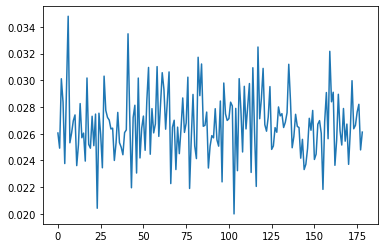

In [15]:
import matplotlib.pyplot as plt


fit_points = data.loc[data['deltaHeading'] < 0.25].copy()

fit_points['lon'] = fit_points['lon'] - variables[2]
plt.plot(all_curves['lon'], all_curves['lat'])
plt.scatter(fit_points['lon'], fit_points['lat'], alpha=0.3, color='green')

plt.figure()

fit_points = bad_data.loc[bad_data['deltaHeading'] < 0.25].copy()

fit_points['lon'] = fit_points['lon'] - bad_vars[2]
plt.plot(all_curves['lon'], all_curves['lat'])
plt.scatter(fit_points['lon'], fit_points['lat'], alpha=0.3, color='green')

plt.figure()

plt.plot(losses)

In [12]:
variables

array([6.41851133e+01, 1.00000099e-02, 0.00000000e+00])

In [13]:
fit_points

,pointNumber,lon,lat,time,heading_x,heading_y,stress,deltaHeading,deltaStress
357,1,208.630000,-63.480000,357,298.345694,298.282294,25.351059,0.063400,-0.198771
716,2,208.749713,-63.543963,356,297.886436,297.653164,25.480335,0.233272,-0.218779
1435,4,208.990520,-63.668951,355,296.977563,297.142916,25.562144,0.165353,-0.238615
1794,5,209.111601,-63.729988,354,296.528006,296.517055,25.733288,0.010952,-0.258618
2153,6,209.233126,-63.790061,353,296.081739,295.892977,25.925055,0.188762,-0.278553
...,...,...,...,...,...,...,...,...,...
178320,496,289.123896,-68.420528,120,255.439262,255.592443,84.772697,0.153180,0.352114
178679,497,289.284967,-68.378249,119,255.145319,255.323470,84.463813,0.178151,0.363585
179038,498,289.446110,-68.335064,118,254.850169,255.057000,84.144100,0.206832,0.375085
179396,499,289.607328,-68.290966,116,254.553858,254.370475,83.426926,0.183383,0.398621


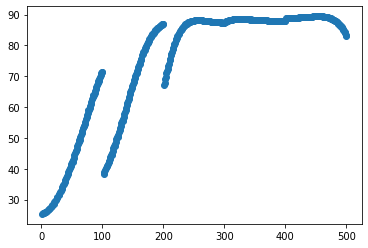

In [16]:
plt.scatter(fit_points['pointNumber'], fit_points['stress'])

## Adam optimizer from `fitting` module

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import curves.bezier as bezier
import curves.fitCurves as fit
import StressTools as tools
import utils
import fitting

interior = utils.import_interior('interior1')

TOLERANCE = 1

min_vals = np.array([0, 0.1, 0])
max_vals = np.array([360, 1, 360])
constraints = [
    dict(wrapValues=True, minValue=1e-8, maxValue=1),
    dict(minValue=1e-8, maxValue=1),
    dict(minValue=0, maxValue=1)
]

delphi = pd.read_csv("./obsData/DelphiLonLatAT.txt", header=None, sep=' ', names=['lon', 'lat'])
delphi = delphi.sort_values(['lon', 'lat'])

arcs = [
    delphi[0:9],
    delphi[9:18],
    delphi[18:27],
    delphi[27:34],
    delphi[34:]
]


all_curves = None

for index, arc in enumerate(arcs):
    startingPoint = index * 100 + 1
    curve = fitting.fit_arc(arc, startingPoint=startingPoint, output_points=100)
    all_curves = curve if all_curves is None else pd.concat([all_curves, curve], ignore_index=True)
    

alex = pd.read_csv("./obsData/AlexLonLatCut.txt", header=None, sep=' ', names=['lon', 'lat'])
alex = alex.sort_values(['lon', 'lat'])


arcs = [
    alex[0:26],
    alex[26:50],
    alex[50:]
]

alex_curves = None
for index, arc in enumerate(arcs):
    startingPoint = alex_curves.shape[0] + 1 if alex_curves is not None else 1
    curve = fitting.fit_arc(arc, startingPoint=startingPoint, output_points=100, max_error=0.01135)
    alex_curves = curve if alex_curves is None else pd.concat([alex_curves, curve], ignore_index=True)


In [2]:
import fitting
import matplotlib.pyplot as plt

def check_fit(params, minVals, maxVals, curve, interior, tolerance=0.25):
    if len(params) == 3:
        variables = params * (max_vals - min_vals) + min_vals # denormalize
    else:
        variables = params * (max_vals[0:2:] - min_vals[0:2:]) + min_vals[0:2:]
        
    plt.figure()
    data = fitting.match_stresses(curve, variables, interior)
    fit_points = data.loc[data['deltaHeading'] < tolerance].copy()
    
    if len(variables) >= 3:
        fit_points['lon'] = fit_points['lon'] - variables[2]
    
    plt.plot(curve['lon'], curve['lat'])
    plt.scatter(fit_points['lon'], fit_points['lat'], alpha=0.3, color='green')
    
    plt.figure()
    
    plt.scatter(fit_points['pointNumber'], fit_points['stress'])
    
    print(np.array(variables))

In [3]:
import fitting

numParams = 3
start_params = [np.random.rand() for iter in range(numParams)]
# start_params = [0.2896670862267282, 0.5283622484787509, 0.9282830635227807]

adam = fitting.Adam(alpha=1.e-2)
opt = adam.minimize(
    fitting.test_stress_parameters, 
    all_curves, 
    start_params, 
    interior, 
    constraints=constraints,
    max_iterations=160,
    verbose=True
)

Iteration 1/160 -- Loss Output: 0.05676499296842922 -- Moving Avg Loss: 0.05676499296842922
Iteration 2/160 -- Loss Output: 0.04571203818736495 -- Moving Avg Loss: 0.05123851557789709
Iteration 3/160 -- Loss Output: 0.05250538324325468 -- Moving Avg Loss: 0.051660804799682956
Iteration 4/160 -- Loss Output: 0.047688111744255836 -- Moving Avg Loss: 0.05066763153582617
Iteration 5/160 -- Loss Output: 0.04843043064579316 -- Moving Avg Loss: 0.05022019135781956
Iteration 6/160 -- Loss Output: 0.05773405765440613 -- Moving Avg Loss: 0.05147250240725066
Iteration 7/160 -- Loss Output: 0.04648910695342182 -- Moving Avg Loss: 0.0507605887709894
Iteration 8/160 -- Loss Output: 0.05296580197373684 -- Moving Avg Loss: 0.051036240421332826
Iteration 9/160 -- Loss Output: 0.05707569006836191 -- Moving Avg Loss: 0.05170729038211383
Iteration 10/160 -- Loss Output: 0.05504368805147643 -- Moving Avg Loss: 0.05204093014905009
Iteration 11/160 -- Loss Output: 0.0556436901997001 -- Moving Avg Loss: 0.052

Iteration 89/160 -- Loss Output: 0.029268356739601698 -- Moving Avg Loss: 0.028792738233593896
Iteration 90/160 -- Loss Output: 0.02914329202061569 -- Moving Avg Loss: 0.02895134328561994
Iteration 91/160 -- Loss Output: 0.03408816675206791 -- Moving Avg Loss: 0.02911219470516405
Iteration 92/160 -- Loss Output: 0.03277591580925969 -- Moving Avg Loss: 0.029366366521075372
Iteration 93/160 -- Loss Output: 0.031262590477406996 -- Moving Avg Loss: 0.029489848559554013
Iteration 94/160 -- Loss Output: 0.033296034088868186 -- Moving Avg Loss: 0.029910009134188426
Iteration 95/160 -- Loss Output: 0.03501666358850367 -- Moving Avg Loss: 0.030144264986222056
Iteration 96/160 -- Loss Output: 0.03650544858433321 -- Moving Avg Loss: 0.030520153458947492
Iteration 97/160 -- Loss Output: 0.03538406485445616 -- Moving Avg Loss: 0.030726670190837916
Iteration 98/160 -- Loss Output: 0.024593554365495974 -- Moving Avg Loss: 0.030685110339877517
Iteration 99/160 -- Loss Output: 0.03197596020488623 -- Mo

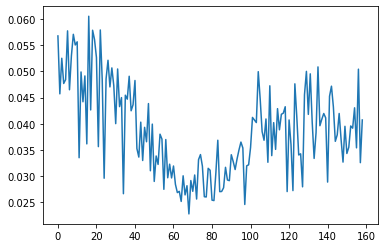

In [4]:
plt.plot(opt[0])

In [5]:
print(f'Best Match: {opt[1]}')
print(f'Final Match: {opt[2]}')

Best Match: {'loss': 0.022792019723007834, 'parameters': array([0.49264817, 0.41799498, 0.24426727])}
Final Match: {'loss': 0.04072617207970515, 'parameters': array([0.35329139, 0.27863818, 0.1049104 ])}


[177.35334067   0.47619548  87.93621819]
[127.18489904   0.35077436  37.7677431 ]


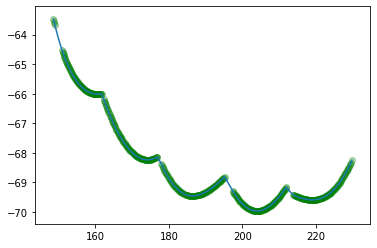

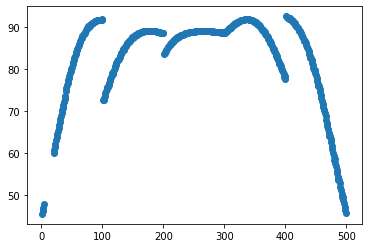

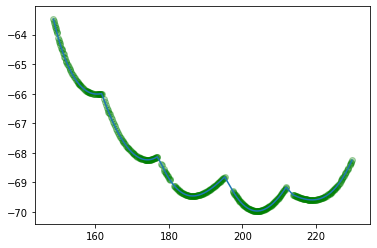

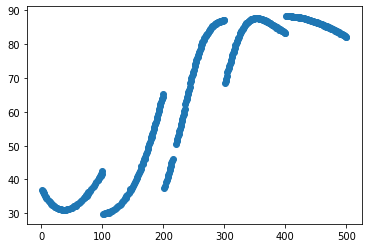

In [6]:
params = opt[1]['parameters']
check_fit(params, min_vals, max_vals, all_curves, interior)

params = opt[2]['parameters']
check_fit(params, min_vals, max_vals, all_curves, interior)

In [12]:
np.array([2.69003376e+02, 2.57206017e-01, 2.07103796e+02]) # @ 150 iterations round 1
np.array([15.93084616,  0.53219007, 37.23026401]) # @ 150 iterations round 2

array([15.93084616,  0.53219007, 37.23026401])

## Try Fitting Alex

In [8]:
import fitting

constraints = [
    dict(wrapValues=True, minValue=1e-8, maxValue=1),
    dict(minValue=1e-8, maxValue=1),
    dict(minValue=0, maxValue=1)
]

numParams = 3
start_params = [np.random.rand() for iter in range(numParams)]
# start_params = [188.04192212, 0.21281051, 155.38088508]

optimizer = fitting.Adam()
# optimizer = fitting.Nesterov()


opt = optimizer.minimize(
    fitting.test_stress_parameters, 
    alex_curves, 
    start_params, 
    interior,
    constraints=constraints,
    max_iterations=500,
    verbose=True
)

Iteration 1/500 -- Loss Output: 0.03814558346475776 -- Moving Avg Loss: 0.03814558346475776
Iteration 2/500 -- Loss Output: 0.0380966819233171 -- Moving Avg Loss: 0.03812113269403743
Iteration 3/500 -- Loss Output: 0.037280159878460575 -- Moving Avg Loss: 0.037840808422178476
Iteration 4/500 -- Loss Output: 0.036963450083938414 -- Moving Avg Loss: 0.03762146883761846
Iteration 5/500 -- Loss Output: 0.03581280823963039 -- Moving Avg Loss: 0.037259736718020846
Iteration 6/500 -- Loss Output: 0.03282863431038712 -- Moving Avg Loss: 0.03652121965008189
Iteration 7/500 -- Loss Output: 0.04131201831945473 -- Moving Avg Loss: 0.037205619459992297
Iteration 8/500 -- Loss Output: 0.028167524396849754 -- Moving Avg Loss: 0.03607585757709948
Iteration 9/500 -- Loss Output: 0.031641070946313604 -- Moving Avg Loss: 0.035583103507012166
Iteration 10/500 -- Loss Output: 0.03908318434500204 -- Moving Avg Loss: 0.035933111590811154
Iteration 11/500 -- Loss Output: 0.3297395048228803 -- Moving Avg Loss:

Iteration 90/500 -- Loss Output: 0.034776929978025714 -- Moving Avg Loss: 0.22567239696191635
Iteration 91/500 -- Loss Output: 0.5820294226456216 -- Moving Avg Loss: 0.23977362304538852
Iteration 92/500 -- Loss Output: 0.9893520274537919 -- Moving Avg Loss: 0.27790240098801955
Iteration 93/500 -- Loss Output: 0.03453065347993824 -- Moving Avg Loss: 0.27547961198967624
Iteration 94/500 -- Loss Output: 0.8369074525608217 -- Moving Avg Loss: 0.29849025456799017
Iteration 95/500 -- Loss Output: 0.5431296018794657 -- Moving Avg Loss: 0.2940238176372014
Iteration 96/500 -- Loss Output: 0.034214169281529434 -- Moving Avg Loss: 0.27147711147481396
Iteration 97/500 -- Loss Output: 1.1655725234900993 -- Moving Avg Loss: 0.31691441086818467
Iteration 98/500 -- Loss Output: 0.5751629750036157 -- Moving Avg Loss: 0.3323897245471249
Iteration 99/500 -- Loss Output: 0.035548562438730974 -- Moving Avg Loss: 0.3323141894555738
Iteration 100/500 -- Loss Output: 1.2592289199652937 -- Moving Avg Loss: 0.3

Iteration 179/500 -- Loss Output: 0.7556364420950724 -- Moving Avg Loss: 0.7620035680829561
Iteration 180/500 -- Loss Output: 0.7402965768259478 -- Moving Avg Loss: 0.7306644046596636
Iteration 181/500 -- Loss Output: 0.48131456710446635 -- Moving Avg Loss: 0.7384709110752651
Iteration 182/500 -- Loss Output: 0.6842935184475823 -- Moving Avg Loss: 0.7514433567086098
Iteration 183/500 -- Loss Output: 0.8973164422376336 -- Moving Avg Loss: 0.7148196950684128
Iteration 184/500 -- Loss Output: 0.9942475109365406 -- Moving Avg Loss: 0.700777575385946
Iteration 185/500 -- Loss Output: 1.4495834939098888 -- Moving Avg Loss: 0.7569460579873721
Iteration 186/500 -- Loss Output: 0.0589028262930241 -- Moving Avg Loss: 0.7045609181163748
Iteration 187/500 -- Loss Output: 0.04409351399281195 -- Moving Avg Loss: 0.6875215219272462
Iteration 188/500 -- Loss Output: 0.5499799126703129 -- Moving Avg Loss: 0.6968691981554771
Iteration 189/500 -- Loss Output: 0.6087221177851773 -- Moving Avg Loss: 0.7193

Iteration 268/500 -- Loss Output: 0.08370386108840998 -- Moving Avg Loss: 0.23951098899687348
Iteration 269/500 -- Loss Output: 0.0905682467405854 -- Moving Avg Loss: 0.21399255754210839
Iteration 270/500 -- Loss Output: 0.04833462845244803 -- Moving Avg Loss: 0.21409885945472026
Iteration 271/500 -- Loss Output: 0.05429348258258037 -- Moving Avg Loss: 0.2095102044025359
Iteration 272/500 -- Loss Output: 0.7644208698949784 -- Moving Avg Loss: 0.238013456490679
Iteration 273/500 -- Loss Output: 0.7845970879634837 -- Moving Avg Loss: 0.2327906406713312
Iteration 274/500 -- Loss Output: 0.05178194963401899 -- Moving Avg Loss: 0.2331071821517874
Iteration 275/500 -- Loss Output: 0.12063585943980941 -- Moving Avg Loss: 0.23542725600209477
Iteration 276/500 -- Loss Output: 0.27481823619609985 -- Moving Avg Loss: 0.23410848188061856
Iteration 277/500 -- Loss Output: 0.568421651709094 -- Moving Avg Loss: 0.25470734200559103
Iteration 278/500 -- Loss Output: 0.5679549205768123 -- Moving Avg Los

Iteration 356/500 -- Loss Output: 0.05588122018297903 -- Moving Avg Loss: 0.21618444072293436
Iteration 357/500 -- Loss Output: 0.29221205613545215 -- Moving Avg Loss: 0.2072711690349194
Iteration 358/500 -- Loss Output: 0.051435587881868625 -- Moving Avg Loss: 0.20644372302410377
Iteration 359/500 -- Loss Output: 0.04796283640794506 -- Moving Avg Loss: 0.2058781074509172
Iteration 360/500 -- Loss Output: 0.04415719389446063 -- Moving Avg Loss: 0.20536494472583647
Iteration 361/500 -- Loss Output: 0.05498841348067856 -- Moving Avg Loss: 0.2056116078009944
Iteration 362/500 -- Loss Output: 0.05163196347623142 -- Moving Avg Loss: 0.1835852914475989
Iteration 363/500 -- Loss Output: 0.07944006415484998 -- Moving Avg Loss: 0.1702117358249349
Iteration 364/500 -- Loss Output: 0.6135977455889158 -- Moving Avg Loss: 0.193144498385571
Iteration 365/500 -- Loss Output: 0.053674515847753686 -- Moving Avg Loss: 0.1934918282882149
Iteration 366/500 -- Loss Output: 0.053699079744323835 -- Moving Av

Iteration 444/500 -- Loss Output: 0.044637717597470934 -- Moving Avg Loss: 0.09648637010568137
Iteration 445/500 -- Loss Output: 0.04302168118037463 -- Moving Avg Loss: 0.09614541983549865
Iteration 446/500 -- Loss Output: 0.047711199056365054 -- Moving Avg Loss: 0.09623887620140714
Iteration 447/500 -- Loss Output: 0.05000801177791634 -- Moving Avg Loss: 0.09680198451499812
Iteration 448/500 -- Loss Output: 0.05817502601404893 -- Moving Avg Loss: 0.09736099403615579
Iteration 449/500 -- Loss Output: 0.051277537660700305 -- Moving Avg Loss: 0.09784536282140534
Iteration 450/500 -- Loss Output: 0.05940501069130947 -- Moving Avg Loss: 0.09849606927652209
Iteration 451/500 -- Loss Output: 0.04967449292785336 -- Moving Avg Loss: 0.09897400250207625
Iteration 452/500 -- Loss Output: 0.046506267322785025 -- Moving Avg Loss: 0.09885442542861597
Iteration 453/500 -- Loss Output: 0.045103816791523255 -- Moving Avg Loss: 0.09454065358566666
Iteration 454/500 -- Loss Output: 0.046015272928093265 

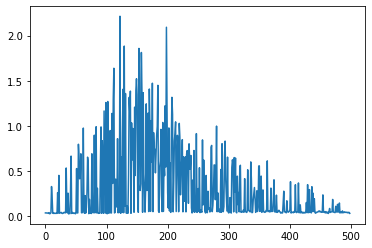

In [9]:
plt.plot(opt[0])

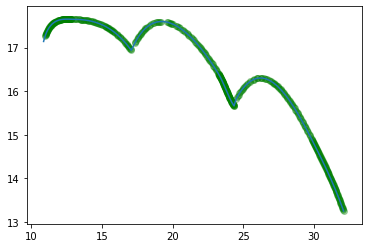

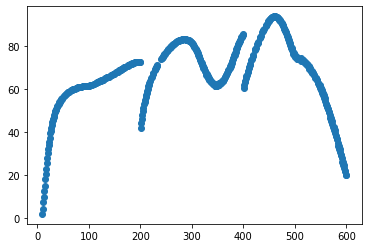

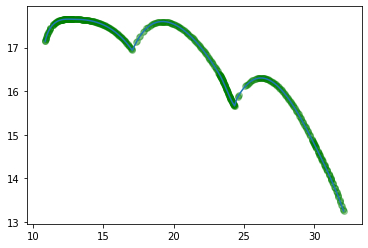

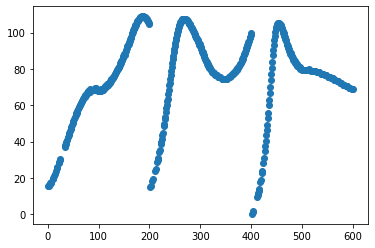

In [13]:

params = opt[1]['parameters']
check_fit(params, min_vals, max_vals, alex_curves, interior, tolerance=0.25)

params = opt[2]['parameters']
check_fit(params, min_vals, max_vals, alex_curves, interior, tolerance=0.25)

In [11]:
min_vals = np.array([0, 0.1, 0])
max_vals = np.array([360, 1, 360])

params = opt[1]['parameters']
size = len(params)

variables = params * (max_vals[0:size] - min_vals[0:size]) + min_vals[0:size]

print(variables)

params = opt[2]['parameters']
size = len(params)

variables = params * (max_vals[0:size] - min_vals[0:size]) + min_vals[0:size]
print(variables)

[108.76555361   0.23533684  88.25237391]
[91.82375632  0.19298202 71.31054267]


In [8]:
min_vals = np.array([0, 0.1, 0])
max_vals = np.array([360, 1, 360])

size = len(start_params)

variables = start_params * (max_vals[0:size] - min_vals[0:size]) + min_vals[0:size]
variables

array([ 67.74356171,   0.4546398 , 187.97578358])

In [9]:
from IPython.display import Math, HTML

def load_mathjax_in_cell_output():
  display(HTML("<script src='https://www.gstatic.com/external_hosted/"
               "mathjax/latest/MathJax.js?config=default'></script>"))
get_ipython().events.register('pre_run_cell', load_mathjax_in_cell_output)

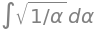

In [19]:
import sympy
sympy.init_printing()
x = sympy.symbols('alpha')
func = sympy.Integral(sympy.sqrt(1 / x), x)
func

In [10]:
# alex params without longitude
alex_good = [0.60366618, 0.70068182]

[{'wrapValues': True, 'minValue': 1e-08, 'maxValue': 1},
 {'minValue': 1e-08, 'maxValue': 1},
 {'minValue': 0, 'maxValue': 1}]